Мы владеем сетью магазинов, в которых продаются различные товары.  

Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине.  

Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.  

Описание датасета:

Variable	Description  
- Item_Identifier	Id продукта  
- Item_Weight	Вес продукта  
- Item_Fat_Content	Содержание жира в продукте  
- Item_Visibility	%полок, отведенный под наш продукт в конкретном магазине  
- Item_Type	Категория продукта  
- Item_MRP	Максимальная цена продажи продукта  
- Outlet_Identifier	Идентификатор магазина  
- Outlet_Establishment_Year	Год открытия магазина  
- Outlet_Size	Площадь магазина  
- Outlet_Location_Type	Тип города, в котором расположен магазин  
- Outlet_Type	Признак является ли магазин продуктовым или супермаркетом  
- Item_Outlet_Sales	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать  

В результате работы должен получиться:  
- Jupyter-ноутбук с моделью  
- Признаки, влияющие больше всего на уровень продаж  
- Датасет, если после ваших манипуляций он отличается от исходного;  
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

Баллы	Что надо сделать  
10	Провести EDA  
10	Обработать категориальные признаки   
10	Устранить пропущенные значения  
10	Изучить корреляцию признаков с данными о продажах  
10	Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели  
20	Построить и подобрать оптимальные параметры для любой линейной модели  
20	Построить и подобрать оптимальные параметры для любой нелинейной модели  
20	Провести стекинг нескольких моделей  
10	Оценить качество модели на отложенной выборке  
10	Выбрать топ 3 признака больше всего влияющие на объемы продаж  

Все шаги решения должны сопровождаться подробным описанием полученных результатов и обоснованием выбора того или иного шага!  
За отсутствие описания так же будут снижаться баллы.  

Максимальное доступное количество баллов - 130  
Для получения зачета надо набрать минимум 80 баллов  
Для получения зачета с отличием надо набрать минимум 120 баллов  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Провести EDA

In [3]:
# посмотрим глазами основные характеристики датасета

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [6]:
columns_cat = data.select_dtypes(object).columns
columns_digit = data.select_dtypes(exclude=object).columns

print(f'Количество категориальных переменных: {len(columns_cat)}')
print(f'Количество количественных переменных: {len(columns_digit)}')

Количество категориальных переменных: 7
Количество количественных переменных: 5


In [7]:
# есть странный min=0 у признака Item_Visibility, а может и не странный

# есть нулевые значения Item_Weight, Outlet_Size
# много категорильных переменных, необходимо с ними поработать

In [8]:
columns_digit

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

# Устранить пропущенные значения

In [9]:
# Item_Weight

In [10]:
data[data.Item_Weight.isna() == 1].count()
data[data.Item_Weight.isna() == 1]

# 1463 нулевых значения; 6113 ненулевых значения; 
# гипотезы:
# - это островки, которые реально не имеют признака. Можно уставить нулевыи или заполнить отрицательным значением
# - значение на самом деле есть, но по какой-то причине отсутствуют. Необходимо предсказать значения признака

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [11]:
data[data.Item_Weight.isna() == 1].Item_Type.value_counts()

Fruits and Vegetables    213
Snack Foods              212
Household                151
Frozen Foods             138
Dairy                    116
Baking Goods             112
Canned                   110
Health and Hygiene        90
Meat                      88
Soft Drinks               71
Breads                    47
Others                    32
Hard Drinks               31
Breakfast                 21
Starchy Foods             18
Seafood                   13
Name: Item_Type, dtype: int64

In [12]:
data[data.Item_Weight.isna() == 0].Item_Type.value_counts()

Fruits and Vegetables    1019
Snack Foods               988
Household                 759
Frozen Foods              718
Dairy                     566
Canned                    539
Baking Goods              536
Health and Hygiene        430
Soft Drinks               374
Meat                      337
Breads                    204
Hard Drinks               183
Others                    137
Starchy Foods             130
Breakfast                  89
Seafood                    51
Name: Item_Type, dtype: int64

In [13]:
# кардинального различия по группам продуктов между продуктами со значениями и без нет. 
# скорее всего вес у этих позиций какой-то все же есть
# Можно пробовать заполнить нули через предсказания

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
d = defaultdict(LabelEncoder)

In [15]:
tmp_df = data.copy()

In [16]:
tmp_df_cat = tmp_df[columns_cat].astype(str)
tmp_df_digit = tmp_df[columns_digit]

In [17]:
le = LabelEncoder()

In [18]:
tmp_df_cat = tmp_df_cat.apply(le.fit_transform)

In [19]:
tmp_df = tmp_df_digit.join(tmp_df_cat)

In [20]:
iw_null = tmp_df[tmp_df.Item_Weight.isna() == 1].drop(['Item_Weight','Outlet_Size'], axis=1)

iw_data = tmp_df[tmp_df.Item_Weight.isna() == 0].drop(['Item_Weight','Outlet_Size'], axis=1)
iw_data_target = tmp_df[tmp_df.Item_Weight.isna() == 0].Item_Weight

In [21]:
X_train, X_test, y_train, y_test  = train_test_split(iw_data, iw_data_target, test_size=0.25, random_state=42)

In [22]:
rf_iw = RandomForestRegressor(n_estimators=500,n_jobs=-1)

In [23]:
rf_iw.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [24]:
predictions_iw = rf_iw.predict(X_test)

In [25]:
mean_squared_error(y_test, predictions_iw)

7.14920816110939

In [26]:
predictions_iw_real = rf_iw.predict(iw_null)

In [27]:
tmp_df.Item_Weight.loc[iw_null.index] = predictions_iw_real
data.Item_Weight.loc[iw_null.index] = predictions_iw_real

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
### построили модель RFRegressor`а для предсказания нулевых значений весов и заполнили их. 
# RMSE на тестовой составило 7,09 против просто среднего в 12,85 по признаку. 
# предположим, что это лучше, чем просто угадывать или заполнять нулями пустые значения. 

In [29]:
# Outlet_Size

In [30]:
data[data.Outlet_Size.isna() == 1].count()
data[data.Outlet_Size.isna() == 1]

# 2410 нулевых значения; 6 113 ненулевых значения; 
# гипотезы:
# - это островки, которые реально не имеют признака. Можно уставить нулевыи или заполнить отрицательным значением
# - значение на самом деле есть, но по какой-то причине отсутствуют. Необходимо предсказать значения признака

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [31]:
# поопробуем посмотреть различия по Outlet_Location_Type и Outlet_Type

In [32]:
data[data.Outlet_Size.isna() == 1].Outlet_Location_Type.value_counts()

Tier 2    1855
Tier 3     555
Name: Outlet_Location_Type, dtype: int64

In [33]:
data[data.Outlet_Size.isna() == 0].Outlet_Location_Type.value_counts()

Tier 3    2795
Tier 1    2388
Tier 2     930
Name: Outlet_Location_Type, dtype: int64

In [34]:
data[data.Outlet_Size.isna() == 1].Outlet_Type.value_counts()

Supermarket Type1    1855
Grocery Store         555
Name: Outlet_Type, dtype: int64

In [35]:
data[data.Outlet_Size.isna() == 0].Outlet_Type.value_counts()

Supermarket Type1    3722
Supermarket Type3     935
Supermarket Type2     928
Grocery Store         528
Name: Outlet_Type, dtype: int64

In [36]:
### явно определить, что отсутствующие признаки относятся к какому-то конкретному типо нельзя
# попробуем построить классификатор для определения этого признака

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
os_null = tmp_df[tmp_df.Outlet_Size == 3].drop(['Item_Weight','Outlet_Size'], axis=1)

os_data = tmp_df[tmp_df.Outlet_Size != 3].drop(['Item_Weight','Outlet_Size'], axis=1)
os_data_target = tmp_df[tmp_df.Outlet_Size != 3].Outlet_Size

In [39]:
from sklearn.preprocessing import label_binarize

In [40]:
os_data_target = label_binarize(os_data_target, classes=[0, 1, 2])
n_classes = os_data_target.shape[1]

In [41]:
X_train, X_test, y_train, y_test  = train_test_split(os_data, os_data_target, test_size=0.25, random_state=42)

In [42]:
from sklearn.multiclass import OneVsRestClassifier

In [43]:
clf_os = OneVsRestClassifier(RandomForestClassifier(n_estimators=100,n_jobs=-1))
y_score = clf_os.fit(X_train, y_train).predict_proba(X_test)

In [44]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from scipy import interp
from itertools import cycle

In [45]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

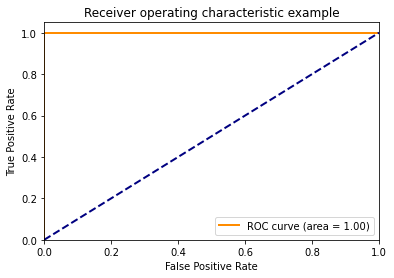

In [46]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<ipython-input-47-ca434529b813>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


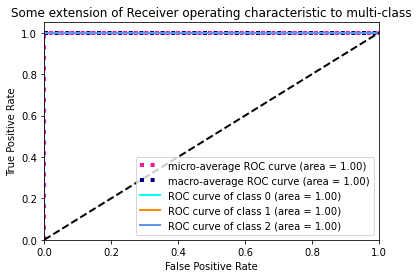

In [47]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [48]:
### кривая явно говорит о переобучении, но не смог прежположить каой-то лучшй способ изменить. :(

In [49]:
predictions_os_real = np.argmax(clf_os.predict(os_null), axis=1)

In [50]:
tmp_df.Outlet_Size.loc[os_null.index] = predictions_os_real
data.Outlet_Size.loc[os_null.index] = predictions_os_real

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [51]:
data.Outlet_Size = np.where(data['Outlet_Size'] == 0, 'High', 
                        np.where(data['Outlet_Size'] == 1, 'Medium', 
                        np.where(data['Outlet_Size'] == 2, 'Small', data['Outlet_Size'])))

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [53]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,High,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [54]:
# нулевые значения заполнены при помощи модели регрессирова и модели классификатора
# возвращен оригинальный датасет с категориальными признаками

# Обработать количественные признаки

In [55]:
columns_digit

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [56]:
df_cont = data[columns_digit]

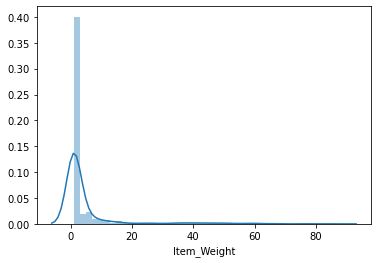

In [57]:
sns.distplot(df_cont.Item_Weight.value_counts())

In [58]:
# Item_Weight
df_cont.Item_Weight.value_counts()

12.15000    86
17.60000    82
13.65000    77
11.80000    76
15.10000    68
            ..
12.82392     1
12.07727     1
16.19534     1
9.92186      1
16.33218     1
Name: Item_Weight, Length: 1878, dtype: int64

In [59]:
df_cont[df_cont.Item_Weight < 10].Item_Weight.value_counts()

9.30000    68
9.80000    61
9.19500    56
9.50000    49
9.60000    49
           ..
9.62382     1
9.62886     1
5.40000     1
8.91113     1
9.86209     1
Name: Item_Weight, Length: 484, dtype: int64

In [60]:
# из-за точного веса в граммах получается очень большое количество уникальных признаков. 
# При этом при округлении их количество можно значитльно снизить. 

In [61]:
df_cont.Item_Weight = df_cont.Item_Weight.round(0)

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [62]:
# Item_Visibility
df_cont.Item_Visibility.value_counts()

0.000000    526
0.076975      3
0.041283      2
0.085622      2
0.187841      2
           ... 
0.092576      1
0.067544      1
0.115168      1
0.146896      1
0.050902      1
Name: Item_Visibility, Length: 7880, dtype: int64

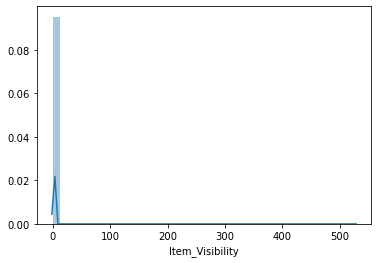

In [63]:
sns.distplot(df_cont.Item_Visibility.value_counts())

In [64]:
df_cont.Item_Visibility.round(2).value_counts()

0.03    911
0.04    850
0.02    812
0.05    684
0.06    574
0.01    566
0.07    542
0.08    533
0.00    532
0.09    400
0.10    350
0.12    292
0.11    288
0.13    242
0.14    230
0.16    167
0.15    139
0.17    133
0.18     86
0.19     45
0.21     26
0.20     19
0.22     14
0.24     14
0.23     12
0.29     12
0.25     11
0.30      9
0.27      8
0.28      8
0.26      6
0.31      5
0.33      2
0.32      1
Name: Item_Visibility, dtype: int64

In [65]:
df_cont.Item_Visibility = df_cont.Item_Visibility.round(2)
# при помощи округления удается сузить пространство признака до 34 разновидностей

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [66]:
#Item_MRP
df_cont.Item_MRP.value_counts()

172.0422    7
188.1872    6
170.5422    6
109.5228    6
196.5084    6
           ..
212.8218    1
190.3872    1
162.6868    1
189.1214    1
51.3008     1
Name: Item_MRP, Length: 5938, dtype: int64

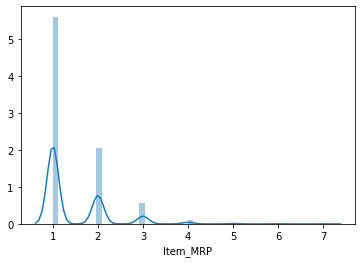

In [67]:
sns.distplot(df_cont.Item_MRP.value_counts())

In [68]:
df_cont.Item_MRP.round(0).value_counts()

197.0    76
122.0    76
178.0    75
110.0    69
121.0    68
         ..
68.0      2
31.0      2
67.0      2
138.0     1
71.0      1
Name: Item_MRP, Length: 229, dtype: int64

In [69]:
df_cont.Item_MRP = df_cont.Item_MRP.round(0)

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [70]:
# Outlet_Establishment_Year
df_cont.Outlet_Establishment_Year.value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

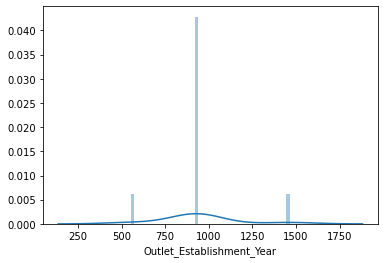

In [71]:
sns.distplot(df_cont.Outlet_Establishment_Year.value_counts())

In [72]:
# Item_Outlet_Sales
df_cont.Item_Outlet_Sales.value_counts()

958.7520     17
1342.2528    16
1845.5976    15
703.0848     15
1278.3360    14
             ..
3167.8764     1
2226.4352     1
1684.4740     1
1574.6170     1
6692.6216     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

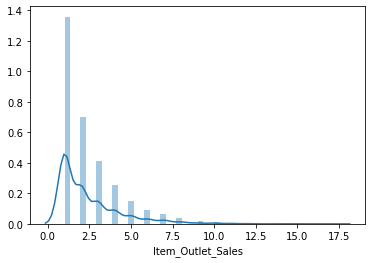

In [73]:
sns.distplot(df_cont.Item_Outlet_Sales.value_counts())

In [74]:
# так как это наша целевая переменная, то стараемся сохранить максимум информации и не производить трансформацию.

In [75]:
df_cont

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.0,0.02,250.0,1999,3735.1380
1,6.0,0.02,48.0,2009,443.4228
2,18.0,0.02,142.0,1999,2097.2700
3,19.0,0.00,182.0,1998,732.3800
4,9.0,0.00,54.0,1987,994.7052
...,...,...,...,...,...
8518,7.0,0.06,215.0,1987,2778.3834
8519,8.0,0.05,108.0,2002,549.2850
8520,11.0,0.04,85.0,2004,1193.1136
8521,7.0,0.15,103.0,2009,1845.5976


# Обработать категориальные признаки

In [76]:
columns_cat

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [78]:
data.Item_Identifier.value_counts()

FDW13    10
FDG33    10
FDX04     9
FDX20     9
FDD38     9
         ..
FDQ60     1
FDC23     1
FDT35     1
DRF48     1
FDE52     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [79]:
data.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [80]:
data.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [81]:
data.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [82]:
data.Outlet_Size.value_counts()

Small     4243
Medium    2793
High      1487
Name: Outlet_Size, dtype: int64

In [83]:
data.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [84]:
data.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [85]:
# с виду с признаками все нормально. 
# Для деревьев можно сделать только OneHotEncoding, но для оценки также другими алгоритмами
# При помощи get dummies преобразуем их

In [86]:
df_cat = pd.get_dummies(data[columns_cat])

In [87]:
df = df_cont.join(df_cat)

In [88]:
df.shape

(8523, 1605)

# Изучить корреляцию признаков с данными о продажах

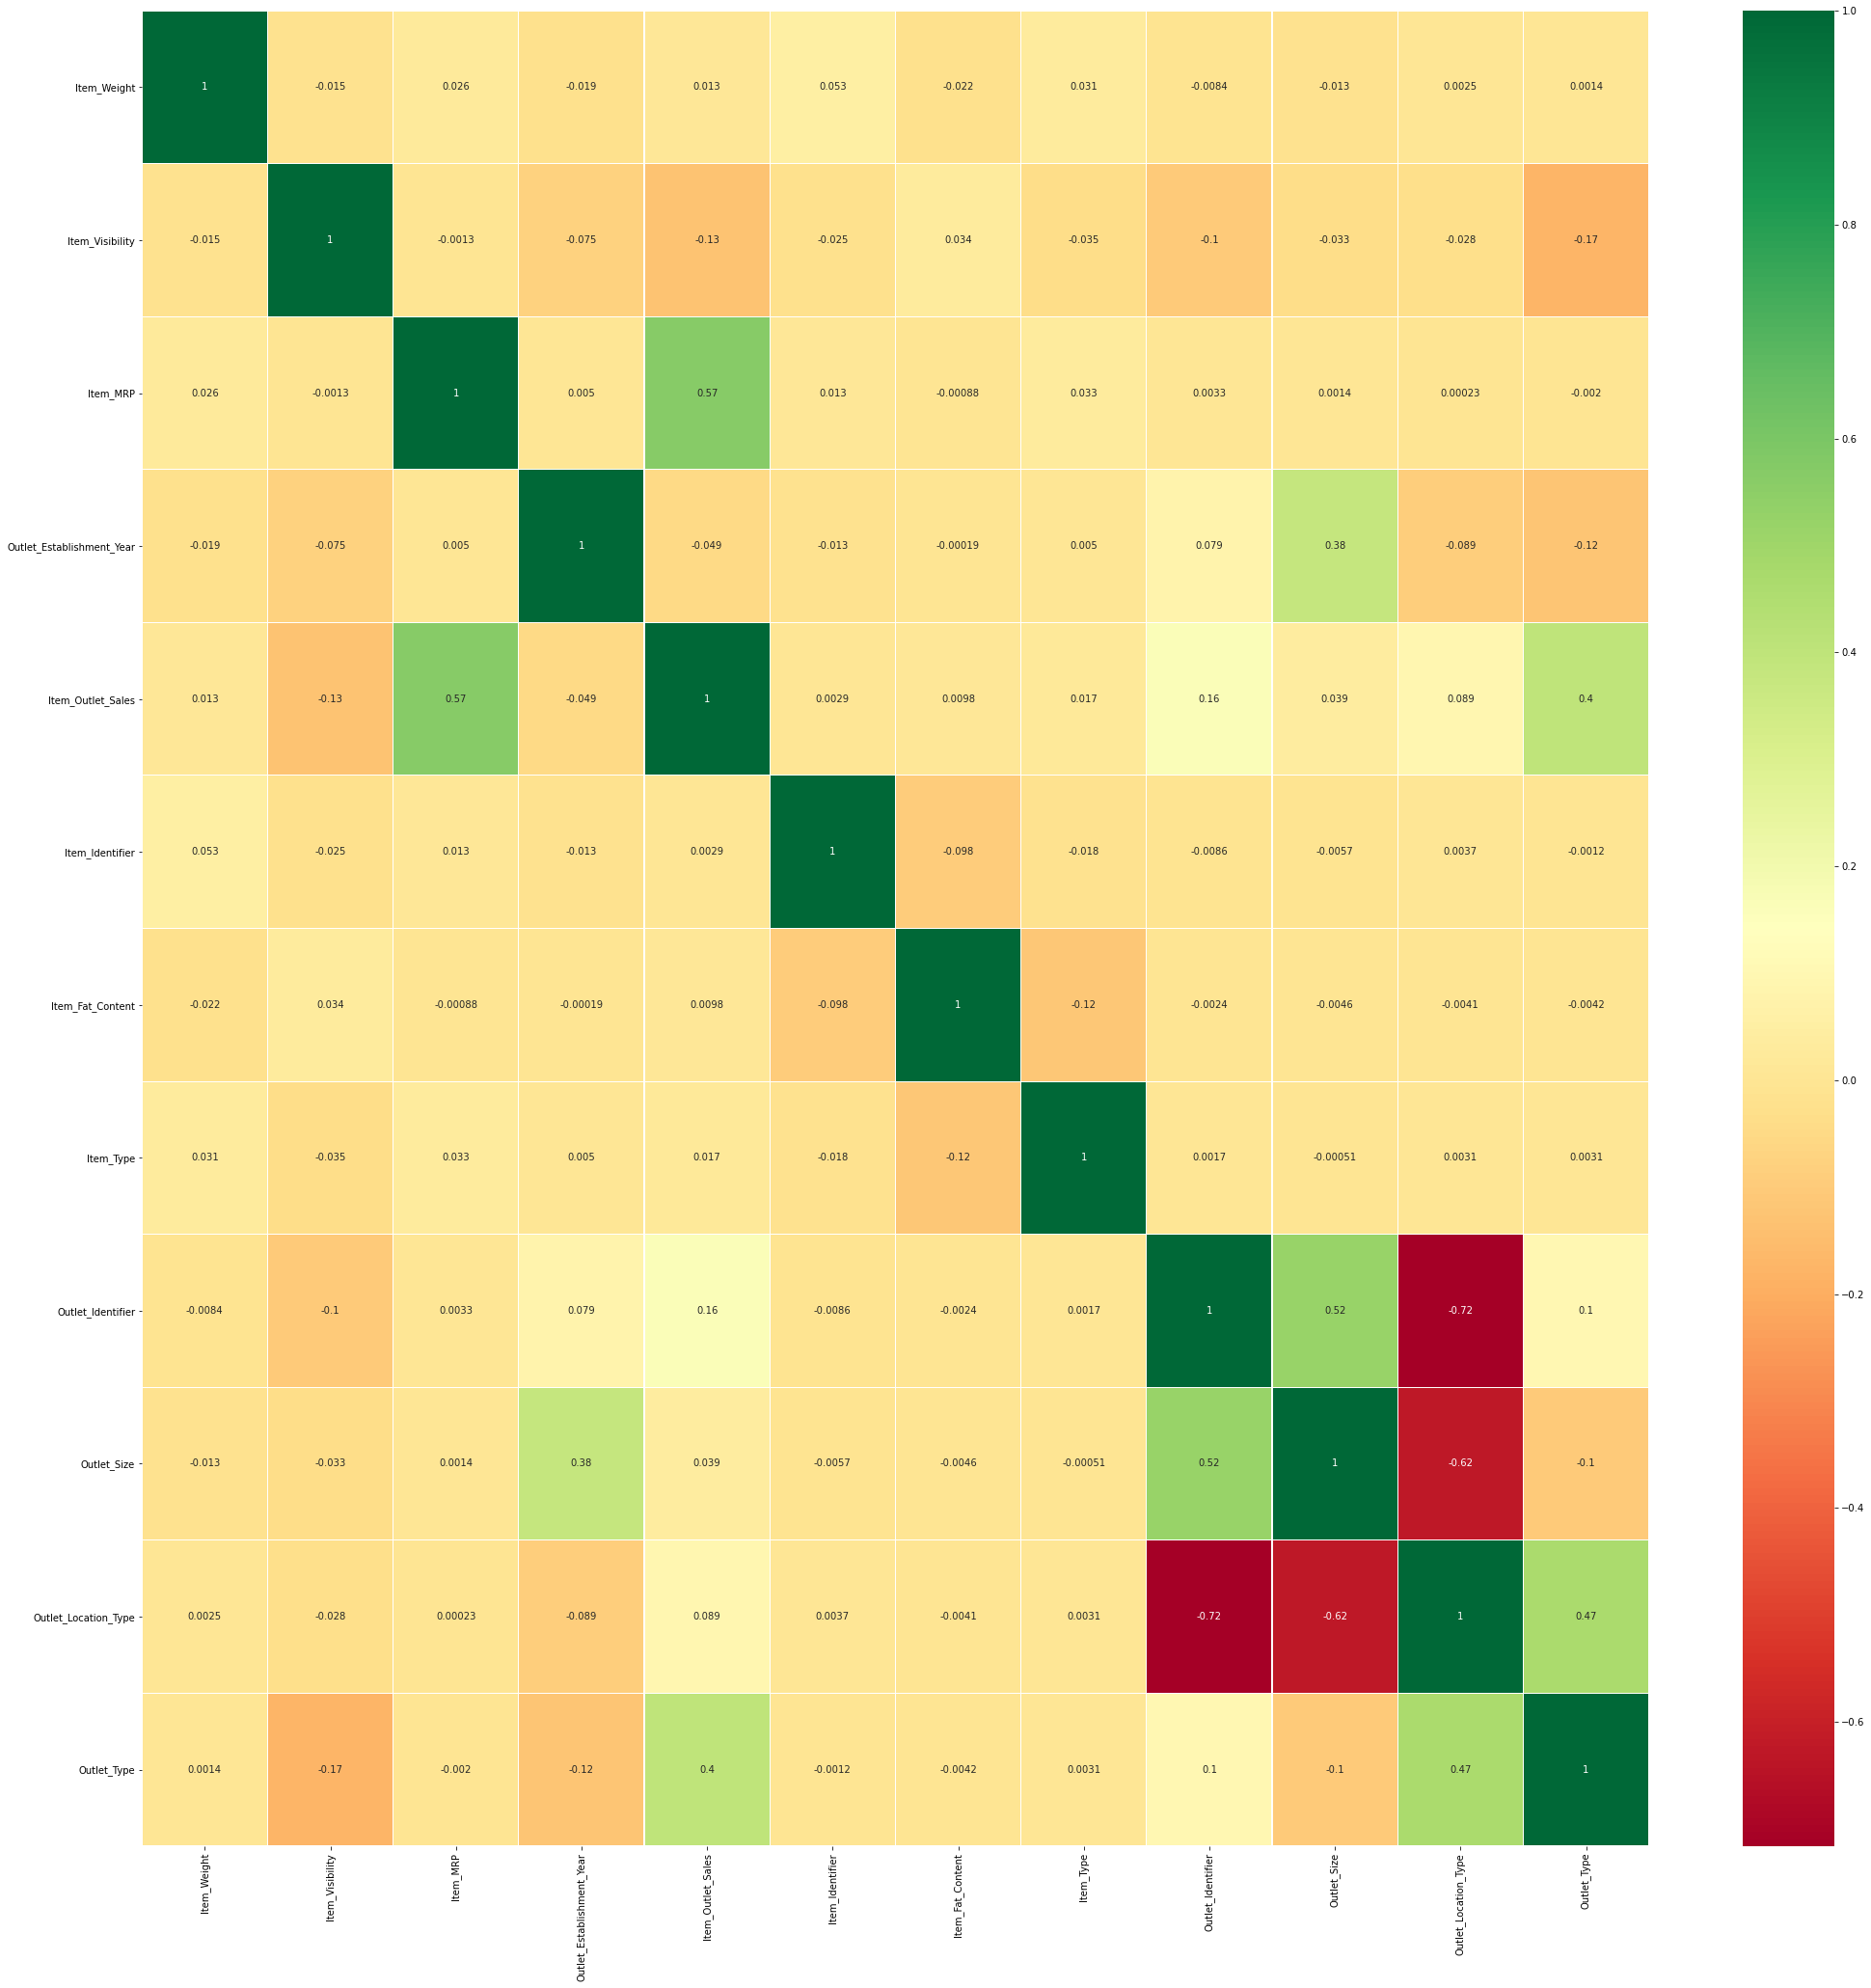

In [89]:
sns.heatmap(tmp_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(35,35)
plt.show()

In [90]:
# Коррекляции в данных есть. Между целевой переменной и остальными, между другими пермененными. Тем не менее, 
# некоторые признаки действительно логически пересекаются, но не взаимоисключаемы. Оставим их. 

# outlet type
# item mrp

### Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели

In [91]:
# Решаем задачу регрессии, поэтому можно для оценки выбирать один из обычных показателей отклонения остатков - MAE, MSE, RMSE. 
# Отдельно мне хотелось бы избежать крупных ошибок модели, поэтому в качестве основного используем показатель RMSE.  

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [93]:
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

In [94]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Построить и подобрать оптимальные параметры для любой линейной модели

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
from sklearn.linear_model import Lasso

In [98]:
params_Lasso = {
    'fit_intercept' : [False, True],
    'normalize' : [False, True]
    }

In [99]:
grid_Lasso = GridSearchCV(Lasso(), param_grid=params_Lasso, cv=5, scoring='neg_mean_squared_error')
grid_Lasso.fit(X_train, y_train)

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2673231367.11428, tolerance: 3446803.2925180644
  model = cd_fast.enet_coordinate_descent(
c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2565005192.24353, tolerance: 3406767.8290331075
  model = cd_fast.enet_coordinate_descent(
c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 745340495.2416301, tolerance: 3468694.967246948
  model = cd_fast.enet_coordinate_descent(
c:\users\f

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'fit_intercept': [False, True],
                         'normalize': [False, True]},
             scoring='neg_mean_squared_error')

In [100]:
print(grid_Lasso.best_params_)
print(grid_Lasso.best_score_)

{'fit_intercept': False, 'normalize': False}
-1314903.0121530134


# Построить и подобрать оптимальные параметры для любой нелинейной модели

In [101]:
from sklearn.svm import SVR

In [102]:
params_svr = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

In [103]:
grid_svr = GridSearchCV(SVR(), param_grid=params_svr, cv=5, scoring='neg_mean_squared_error')
grid_svr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [104]:
print(grid_svr.best_params_)
print(grid_svr.best_score_)

{'kernel': 'linear'}
-1553811.5258236665


# Провести стекинг нескольких моделей

In [105]:
from sklearn.ensemble import StackingRegressor

In [106]:
from sklearn.linear_model import LinearRegression

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
from sklearn.neighbors import KNeighborsRegressor

In [109]:
classifier = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('svm', SVR()),
        ('knn',KNeighborsRegressor())
    ],
RandomForestRegressor())

In [110]:
classifier.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()), ('svm', SVR()),
                              ('knn', KNeighborsRegressor())],
                  final_estimator=RandomForestRegressor())

In [111]:
classifier.named_estimators_['knn']

KNeighborsRegressor()

In [112]:
y_pred_lr = classifier.named_estimators_['lr'].predict(X_test)
y_pred_svm = classifier.named_estimators_['svm'].predict(X_test)
y_pred_knn = classifier.named_estimators_['knn'].predict(X_test)

In [113]:
y_pred = classifier.predict(X_test)

In [114]:
print("RMSE lr: \t", round(np.sqrt(mean_squared_error(y_test, y_pred_lr)),2))
print("RMSE svm: \t", round(np.sqrt(mean_squared_error(y_test, y_pred_svm)),2))
print("RMSE classifier: \t", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))

RMSE lr: 	 14031184922.45
RMSE svm: 	 1775.3
RMSE classifier: 	 1296.42


# Оценить качество модели на отложенной выборке

In [115]:
y_pred_val_lr = classifier.named_estimators_['lr'].predict(X_val)
y_pred_val_svm = classifier.named_estimators_['svm'].predict(X_val)
y_pred_val_knn = classifier.named_estimators_['knn'].predict(X_val)

In [116]:
y_pred_val = classifier.predict(X_val)

In [121]:
print("RMSE lr: \t", round(np.sqrt(mean_squared_error(y_val, y_pred_val_lr)),2))
print("RMSE svm: \t", round(np.sqrt(mean_squared_error(y_val, y_pred_val_svm)),2))
print("RMSE KNN classifier: \t", round(np.sqrt(mean_squared_error(y_val, y_pred_val_knn)),2))

RMSE lr: 	 13736655151.36
RMSE svm: 	 1670.74
RMSE KNN classifier: 	 1209.0


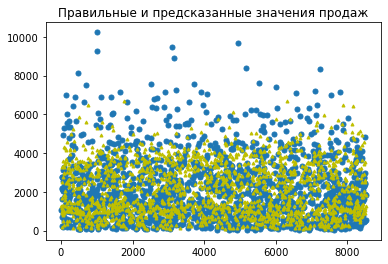

In [120]:
plt.plot(y_val.index, y_val, 'o', markersize = 5)
plt.plot(y_val.index, y_pred_val, 'y^', markersize = 3)
plt.title('Правильные и предсказанные значения продаж')
plt.show()

# Выбрать топ 3 признака больше всего влияющие на объемы продаж

In [122]:
classifier.final_estimator_

RandomForestRegressor()

''

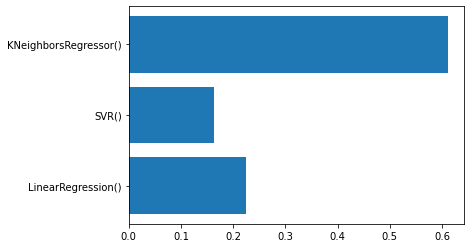

In [123]:
plt.barh(np.arange(len(classifier.final_estimator_.feature_importances_)),
                 classifier.final_estimator_.feature_importances_)
plt.yticks(np.arange(len(classifier.final_estimator_.feature_importances_)),classifier.estimators_)
''